In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import numpy as np
import nltk
import numpy

Using TensorFlow backend.


In [2]:
train_df=pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
test_df=pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')

In [3]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [5]:
train_df['keyword'].value_counts()

fatalities               45
deluge                   42
armageddon               42
harm                     41
damage                   41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 221, dtype: int64

In [6]:
train_df['location'].value_counts()

USA                     104
New York                 71
United States            50
London                   45
Canada                   29
                       ... 
World Wide!!              1
Spring Grove, IL          1
Madrid                    1
St Austell, Cornwall      1
taken by piper curda      1
Name: location, Length: 3341, dtype: int64

In [7]:
train_df['keyword'].isnull().sum()

61

In [8]:
train_df['location'].isnull().sum()

2533

In [9]:
train_df.shape

(7613, 5)

In [10]:
'''import re
train_df['text']=train_df['text'].apply(lambda x:re.sub(r'^http|https?:\/\/.*[\r\n]*','', x))
train_df['text']=train_df['text'].apply(lambda x:re.sub(r'#','', x))
train_df['text']=train_df['text'].apply(lambda x:re.sub(r'@','', x))'''

"import re\ntrain_df['text']=train_df['text'].apply(lambda x:re.sub(r'^http|https?:\\/\\/.*[\r\n]*','', x))\ntrain_df['text']=train_df['text'].apply(lambda x:re.sub(r'#','', x))\ntrain_df['text']=train_df['text'].apply(lambda x:re.sub(r'@','', x))"

In [33]:
#ref https://towardsdatascience.com/creating-the-twitter-sentiment-analysis-program-in-python-with-naive-bayes-classification-672e5589a7ed
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from string import punctuation
class TweetPreprocessor:
    def __init__(self):
        self._stopwords=set(stopwords.words('english') + list(punctuation))
    def preprocess(self,list_of_tweets):
        processed_tweets=[]
        for tweet in list_of_tweets:
            processed_tweets.append(self.processtweet(tweet))
        return processed_tweets
    def processtweet(self,tweet):
        tweet = tweet.lower()
        tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', 'URL', tweet) # remove URLs
        tweet = re.sub('@[^\s]+', 'AT_USER', tweet) # remove usernames
        tweet = re.sub(r'#([^\s]+)', r'\1', tweet) # remove the # in #hashtag
        #tweet = ''.join([word for word in tweet.split() if word not in self._stopwords]) 
        lemmatizer=WordNetLemmatizer()
        tweet = lemmatizer.lemmatize(tweet,'v')
        tweet = lemmatizer.lemmatize(tweet,'n')
        # add ons
        return tweet

In [34]:
tweetprocessor=TweetPreprocessor()
preprocessed=tweetprocessor.preprocess(pd.concat([train_df['text'],test_df['text']]))
preprocessed_text_train=tweetprocessor.preprocess(train_df['text'])
preprocessed_text_test=tweetprocessor.preprocess(test_df['text'])

In [13]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
MAX_WORDS_NUM=20000
tokenizer=Tokenizer(num_words=MAX_WORDS_NUM)
tokenizer.fit_on_texts(preprocessed)
word_index=tokenizer.word_index

In [14]:
print(len(word_index))

19558


In [15]:
MAX_LEN=25
sequences=tokenizer.texts_to_sequences(preprocessed_text_train)
data=pad_sequences(sequences,maxlen=MAX_LEN)
labels=train_df['target']
print(labels.value_counts())

0    4342
1    3271
Name: target, dtype: int64


In [16]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test=train_test_split(data,np.array(list(labels)),test_size=0.2,random_state=123)

In [17]:
embedding_index={}
f=open('/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.100d.txt')
for line in f:
    values=line.split()
    word=values[0]
    coefs=np.asarray(values[1:],dtype='float32')
    embedding_index[word]=coefs

In [18]:
EMBEDDING_DIM=100
countz=0
embedding_matrix=np.zeros((len(word_index)+1,EMBEDDING_DIM))
for word,i in word_index.items():
    embedding_vector=embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i]=embedding_vector
    else:
        countz=countz+1

In [19]:
print(countz)

4913


In [20]:
from tensorflow.keras.layers import Bidirectional,LSTM,Embedding,Dense
kernel_regularizer=tf.keras.regularizers.l2(1e-3)
model=tf.keras.Sequential([
    Embedding(len(word_index)+1,EMBEDDING_DIM,weights=[embedding_matrix],input_length=MAX_LEN,trainable=False),
    Bidirectional(LSTM(128,activation='relu')),
    Dense(1,activation='sigmoid')
])

In [21]:
def build_model(model,X_train,Y_train,X_test,Y_test,lr=1e-4,verbose=2,epochs=15):
    model.compile(loss=keras.losses.BinaryCrossentropy(),optimizer=tf.keras.optimizers.Adam(lr),metrics=['accuracy'])
    model.summary()
    history=model.fit(X_train,Y_train,epochs=epochs,validation_data=(X_test,Y_test),batch_size=128,verbose=verbose)
    return history

In [22]:
history=build_model(model,X_train,Y_train,X_test,Y_test,lr=1e-4,epochs=25)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 25, 100)           1955900   
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               234496    
_________________________________________________________________
dense (Dense)                (None, 1)                 257       
Total params: 2,190,653
Trainable params: 234,753
Non-trainable params: 1,955,900
_________________________________________________________________
Train on 6090 samples, validate on 1523 samples
Epoch 1/25
6090/6090 - 6s - loss: 0.6653 - accuracy: 0.6016 - val_loss: 0.6358 - val_accuracy: 0.7019
Epoch 2/25
6090/6090 - 2s - loss: 0.5805 - accuracy: 0.7296 - val_loss: 0.5378 - val_accuracy: 0.7636
Epoch 3/25
6090/6090 - 2s - loss: 0.4963 - accuracy: 0.7833 - val_loss: 0.4906 - val_accuracy: 0.7715
Epoch 4/25
6090/

In [23]:
def plot(history):
    acc=history.history['accuracy']
    val_acc=history.history['val_accuracy']
    loss=history.history['loss']
    val_loss=history.history['val_loss']
    epochs=range(len(acc))
    plt.plot(epochs,acc)
    plt.plot(epochs,val_acc)
    plt.title('Training accuracy and Validation accuracy')
    plt.figure()
    plt.plot(epochs,loss)
    plt.plot(epochs,val_loss)
    plt.title('Training and validation loss')

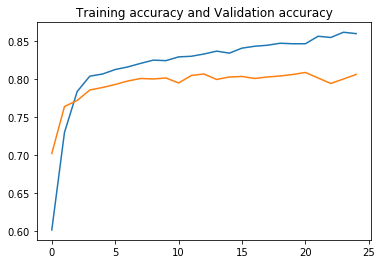

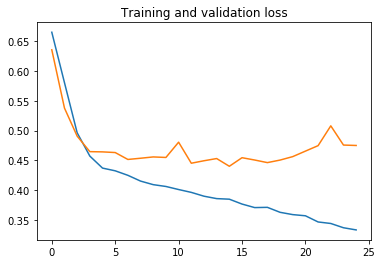

In [24]:
plot(history)

In [25]:
sequences=tokenizer.texts_to_sequences(preprocessed_text_test)
data_for_test=pad_sequences(sequences,maxlen=MAX_LEN)

In [26]:
data_for_test[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,   34,  768,    5,
       1484,  128,   94], dtype=int32)

In [27]:
probs=model.predict(data_for_test)

In [28]:
output_labels=[]
for x in probs:
    if x>=0.5:
        output_labels.append(1)
    else:
        output_labels.append(0)

In [29]:
submission=pd.read_csv('/kaggle/input/nlp-getting-started/sample_submission.csv')
submission['id']=test_df['id']
submission['target']=output_labels

In [30]:
submission.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [31]:
submission['target'].value_counts()

0    2068
1    1195
Name: target, dtype: int64

In [32]:
submission.to_csv('submission.csv',index=False)